<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/notebooks/ECCB_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Data processing

In [ ]:
#DATA
#sequence generation
# (output is the same length as input)
# = what is the most probable next character?
# creating our own dataset from jsut plain text - using semi supervised learning
#source https://www.tensorflow.org/text/tutorials/text_generation
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
complete_text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(complete_text)} characters')
complete_text[:250]

Length of text: 1115394 characters


'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n'

In [ ]:
# The unique characters in the file
vocab = sorted(set(complete_text))
# vocab = set(text)
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)

def text_to_ids(text, vocab=vocab):
  chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
  # chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)
  return chars_to_ids(chars)

text = 'Hi mom!'
ids = text_to_ids(text)
print(ids)
#Comment - tensor is just a fancy array for GPU

tf.Tensor([21 48  2 52 54 52  3], shape=(7,), dtype=int64)


In [ ]:
chars_from_ids = preprocessing.StringLookup(vocabulary=chars_to_ids.get_vocabulary(), invert=True, mask_token=None) #mask token = None - id_from_chars adds [UNK] token, not interested in that one

def ids_to_text(ids):
  # chars_from_ids = preprocessing.StringLookup(vocabulary=chars_to_ids.get_vocabulary(), invert=True, mask_token=None) #mask token = None - id_from_chars adds [UNK] token, not interested in that one
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy()

print(ids_to_text(ids))

b'Hi mom!'


## Creating the dataset for our model

In [ ]:
all_ids = text_to_ids(complete_text)
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
seq_length=100
#We could have some sequences of length 50, some of 150 etc...!
# sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
sequences = ids_dataset.batch(seq_length, drop_remainder=True)

for s in sequences.take(3):
  print(s)
for s in sequences.take(3):
  print(ids_to_text(s))

tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 15 44 45 54 57 44  2 62 44
  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47 44
 40 57  2 52 44  2 58 55 44 40 50  9  1  1 14 51 51 11  1 32 55 44 40 50
  7  2 58 55 44 40 50  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11
  1 38 54 60], shape=(100,), dtype=int64)
tf.Tensor(
[ 2 40 57 44  2 40 51 51  2 57 44 58 54 51 61 44 43  2 57 40 59 47 44 57
  2 59 54  2 43 48 44  2 59 47 40 53  2 59 54  2 45 40 52 48 58 47 13  1
  1 14 51 51 11  1 31 44 58 54 51 61 44 43  9  2 57 44 58 54 51 61 44 43
  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 19 48 57 58 59  7
  2 64 54 60], shape=(100,), dtype=int64)
tf.Tensor(
[ 2 50 53 54 62  2 16 40 48 60 58  2 26 40 57 42 48 60 58  2 48 58  2 42
 47 48 44 45  2 44 53 44 52 64  2 59 54  2 59 47 44  2 55 44 54 55 51 44
  9  1  1 14 51 51 11  1 36 44  2 50 53 54 62  6 59  7  2 62 44  2 50 53
 54 62  6 59  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 25 44
 59  2 

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", ids_to_text(input_example))
    print("Target:", ids_to_text(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


In [ ]:
#Only training dataset
ready_to_train_dataset = dataset.shuffle(buffer_size=10000).batch(batch_size=64)

# Model architecture


In [ ]:
class MyBasicModel(tf.keras.Model):
  def __init__(self, vocab_size, rnn_units):
    super().__init__(self)

    self.onehot = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x,'int64'), vocab_size))
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x= self.onehot(x)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyBasicModel(vocab_size=66, rnn_units=256)

In [ ]:
#TODO showcase simple vs GRU/LSTM?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ready_to_train_dataset, epochs=1)

175/175 [==============================] - 30s 161ms/step - loss: 2.8789 - accuracy: 0.2534


In [ ]:
generate_shakespeare(model, 100)

ROMEO:
Ard thareo thyu diblroui: thy pravebtareece wial, ponas. :fis !oid;
Bo saenoIc
 urasl.sve bembthi's 

________________________________________________________________________________


# Text generation

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

def generate_shakespeare(model, length, start_string='ROMEO:'):
  ids_from_chars = preprocessing.StringLookup(
      vocabulary=list(vocab), mask_token=None)
  chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

  one_step_model = OneStep(model, chars_from_ids, chars_to_ids)

  states = None
  next_char = tf.constant([start_string])
  result = [next_char]

  for n in range(length):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


In [ ]:
generate_shakespeare(model, 100)


ROMEO:

o? Ihyaos wat my,idsethear kfse ie see, sowims faltch'e, anoie'brand y eeyris foit  hispyipsever,  

________________________________________________________________________________


# LSTM/GRU model + Embedding


In [ ]:
#copypasted model
#TODO explain embeddings, GRU?
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(chars_to_ids.get_vocabulary()),
    embedding_dim=256,
    rnn_units=256) #1024

In [ ]:
#TODO showcase simple vs GRU/LSTM?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ready_to_train_dataset, epochs=1)

175/175 [==============================] - 100s 552ms/step - loss: 2.8038 - accuracy: 0.2534


In [ ]:
generate_shakespeare(model, 200, start_string="ROMEO:")

ROMEO:
Momed whisthernswinf wid, wy ye icthey, of wo tho thachinlot wor he wn:
I nonese hamer fone
Whouss thoo arrt-Lind eserelrestou tuvitstho prook, theroug nokdes fost mo shism fally tes, tuy tons nor ke 

________________________________________________________________________________


# Sequence classification 

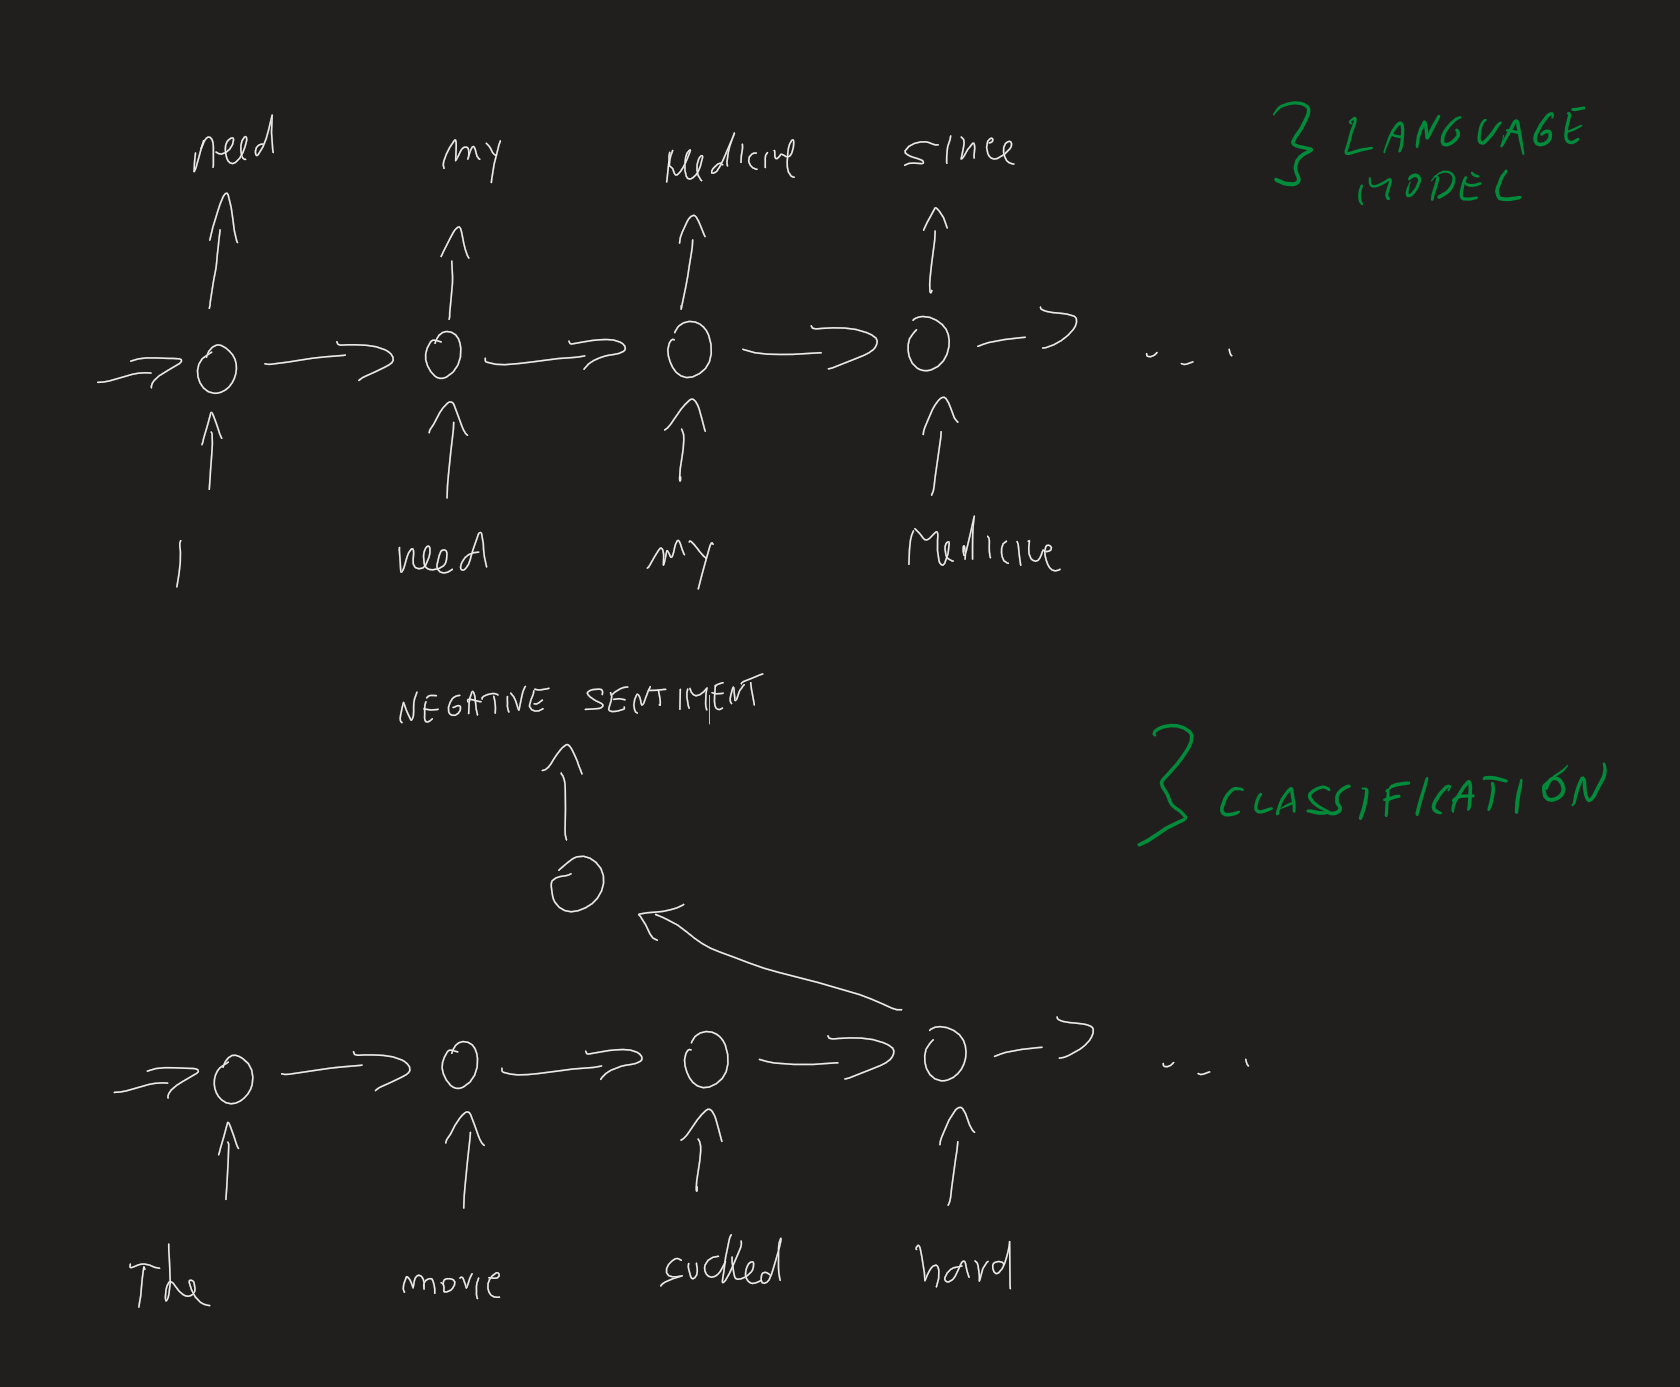

In [ ]:
#TODO https://www.tensorflow.org/text/tutorials/text_classification_rnn
#TODO DROP movie reviews??

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset_og, test_dataset_og = dataset['train'], dataset['test']

train_dataset_og.element_spec

In [ ]:
for example, label in train_dataset_og.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset_og.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset_og.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30) #TODO why constrict validations steps? Delete?

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# sample_text = ('The movie was cool. The animation and the graphics '
              #  'were out of this world. I would recommend this movie.')
sample_text = ('I did not really like the story. The effects were fine, and the overall feel was underwhelming.')
predictions = model.predict(np.array([sample_text]))
if (predictions>=0):
  print('positive') 
else: 
  print('negative')

# Quadruplexes

In [ ]:
#TODO question - why split sequences into 200-lengths? Why not let all be 10000+ chars?
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/train_set_1_1.txt
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/test_set_1_1.txt

--2021-07-13 07:41:53--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/train_set_1_1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63000000 (60M) [text/plain]
Saving to: ‘train_set_1_1.txt’

train_set_1_1.txt   100%[===================>]  60.08M   136MB/s    in 0.4s    

2021-07-13 07:41:56 (136 MB/s) - ‘train_set_1_1.txt’ saved [63000000/63000000]

--2021-07-13 07:41:56--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/test_set_1_1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
nucleo_dic = {
    "A": 0,
    "C": 1,
    "T": 2,
    "G": 3,
    "N": 4,
}

df_train = pd.read_csv("train_set_1_1.txt", sep='\t', names=['sequence', 'label'])

labels_train = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_train['label']))))
dataset_train = df_train['sequence'].tolist()

dataset_ordinal_train = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_train]
# dataset_onehot_train = tf.one_hot(dataset_ordinal_train, depth=5)

print(len(df_train))
dataset = tf.data.Dataset.from_tensor_slices((dataset_ordinal_train, labels_train))
# ohe_dataset = tf.data.Dataset.from_tensor_slices((dataset_onehot_train, labels_train)) #Not used because of embedding layer


df_test = pd.read_csv("test_set_1_1.txt", sep='\t', names=['sequence', 'label'])
print(len(df_test))
labels_test = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_test['label']))))
dataset_test = df_test['sequence'].tolist()
dataset_ordinal_test = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_test]
test_dataset = tf.data.Dataset.from_tensor_slices((dataset_ordinal_test, labels_test))


300000
100000


In [ ]:
ready_to_train_dataset = dataset.shuffle(buffer_size=10000).batch(batch_size=128)
test_dataset = test_dataset.shuffle(buffer_size=10000).batch(batch_size=128)


In [ ]:
for x,y in ready_to_train_dataset.take(1):
  print(x.shape, x)
  print(y.shape, y)

for x,y in test_dataset.take(1):
  print(x.shape, x)
  print(y.shape, y)

(128, 200) tf.Tensor(
[[0 2 3 ... 3 0 0]
 [2 0 0 ... 0 1 0]
 [0 3 1 ... 3 2 3]
 ...
 [3 2 2 ... 2 3 1]
 [4 4 4 ... 4 4 4]
 [2 0 0 ... 0 1 0]], shape=(128, 200), dtype=int32)
(128,) tf.Tensor(
[1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1
 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1], shape=(128,), dtype=int64)
(128, 200) tf.Tensor(
[[4 4 4 ... 4 4 4]
 [0 1 0 ... 0 3 0]
 [1 0 3 ... 0 3 3]
 ...
 [1 0 2 ... 3 3 3]
 [4 4 4 ... 4 4 4]
 [1 0 0 ... 1 1 0]], shape=(128, 200), dtype=int32)
(128,) tf.Tensor(
[0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0
 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0], shape=(128,), dtype=int64)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding( #TODO skip embedding?
        input_dim=5,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(ready_to_train_dataset, epochs=3, validation_data=test_dataset)

Epoch 1/3
2344/2344 [==============================] - 1132s 481ms/step - loss: 0.4623 - accuracy: 0.7649 - val_loss: 0.2946 - val_accuracy: 0.8940
Epoch 2/3
2344/2344 [==============================] - 1133s 483ms/step - loss: 0.2362 - accuracy: 0.9090 - val_loss: 0.2060 - val_accuracy: 0.9219
Epoch 3/3
2344/2344 [==============================] - 1127s 481ms/step - loss: 0.1934 - accuracy: 0.9245 - val_loss: 0.1878 - val_accuracy: 0.9289
